# Features Selection

In this notebook we will report our experiments about the impact of various combinations of features on predictive performance, and, depending on the classifier, how you tackled the task of feature selection.

- Find collinear features as identified by a correlation coefficient greater than a specified value
- Number of optimal features
- Find features importance with Random Forest
- Find features importance with Gradient Boosting



In [2]:
import pandas as pd
import numpy as np
from utils import Config
from utils.extract_features import *
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.feature_selection import RFE
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


config = Config("config/")

E_F = features_dataset(config.preprocess_all)
if config.preprocess_all:
    E_F.prepocess_data()
train_features, training_labels, test_features = E_F.load_features_all()
m = train_features.mean(axis=0)
std = train_features.std(axis=0)
if config.norm:
    train_features = (train_features - m) / std
    test_features = (test_features - m) / std

names = ['overlap_title', 'temp_diff', 'comm_auth', 'num_inc_edges', 'Distance_abstract', 
     'Distance_title', 'shortest_path_dijkstra', 'shortest_path_dijkstra_und',
     'comm_neighbors','no_edge', 'tfidf_distance_corpus', 'tfidf_distance_titles',
     'jaccard_und', 'Resource_allocation']

data = pd.DataFrame(train_features)
data.columns = names

/media/benamira/19793564030D4273/MCsBackup/3A/OMA/NGSA/Assigment/kaggle_competition/utils


## Features correlations

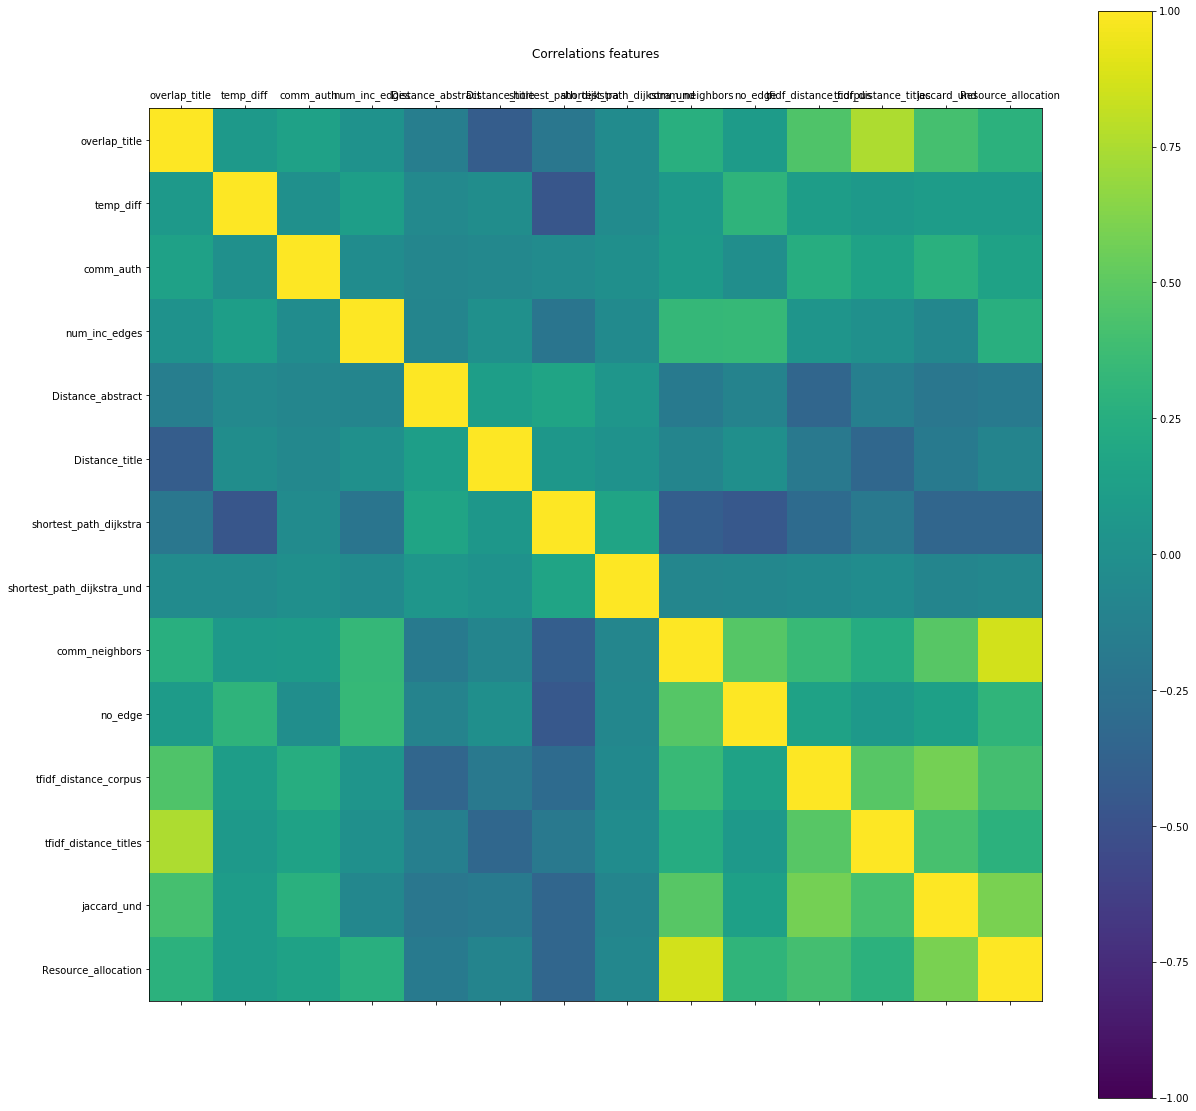

In [3]:
correlations = data.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.title("Correlations features")
plt.show()

In [4]:
cor_all = []
for name in names:
    corr = correlations.index[correlations[name] > 0.9].tolist()
    if len(corr)!=1 :
        cor_all = cor_all + corr
print(cor_all)

[]


## Number of features

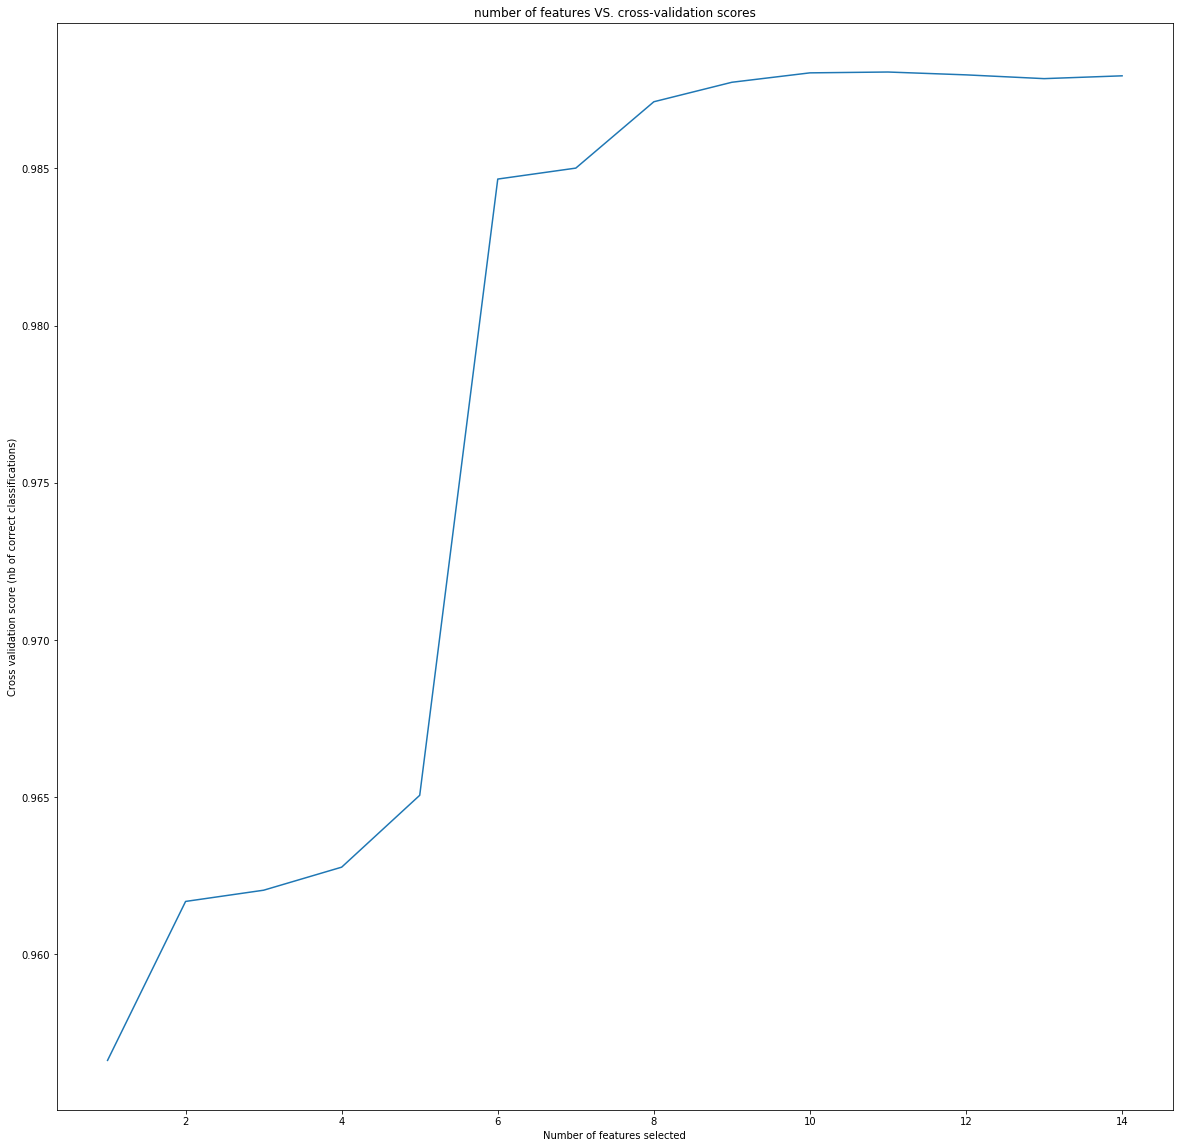

In [7]:
svc = RandomForestClassifier(n_estimators=500)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='f1')
rfecv.fit(train_features, training_labels)

plt.figure(figsize=(20,20))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("number of features VS. cross-validation scores")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Features importances Random Forest, Gradient Boosting

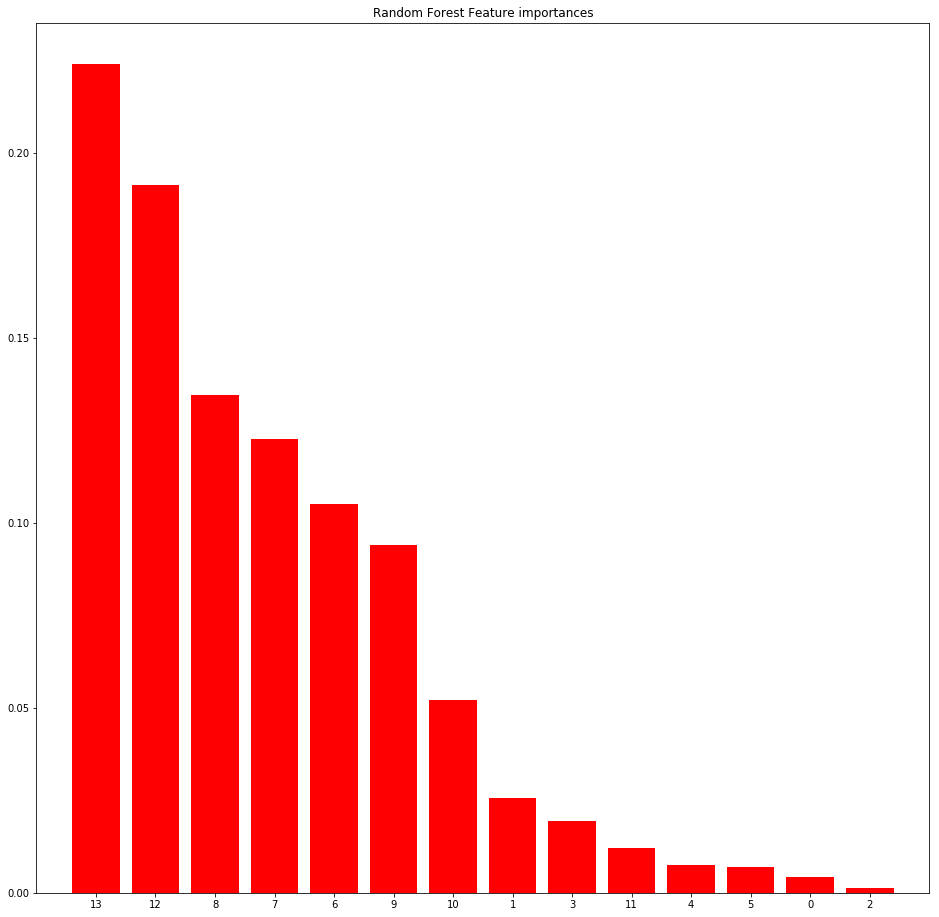

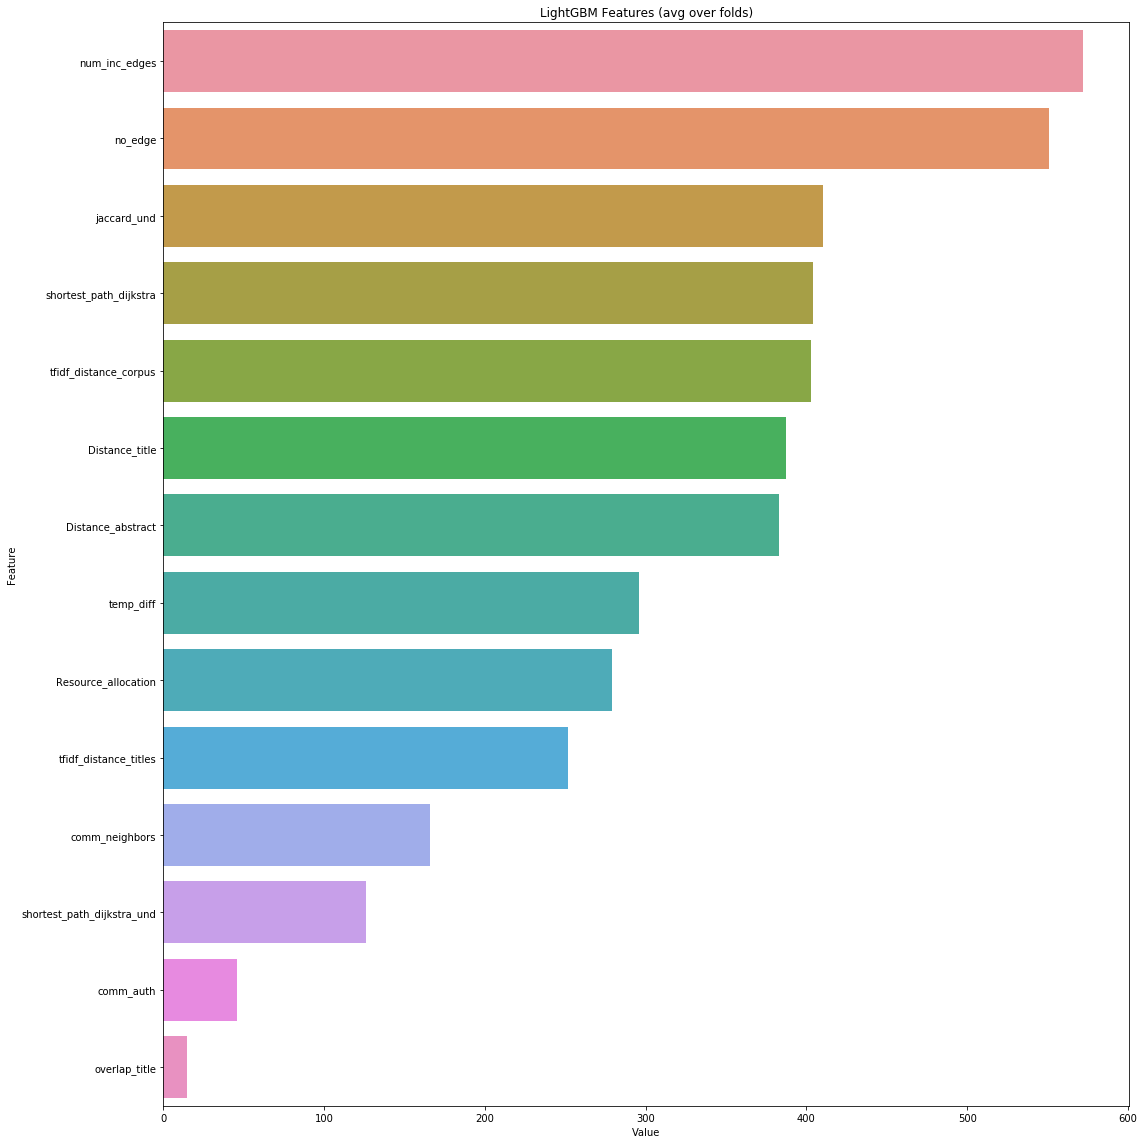

In [11]:
modelGB = lgb.LGBMClassifier(objective='binary', reg_lambda=10, n_estimators=10000)
modelGB.fit(train_features[:int(train_features.shape[0] * 0.99)],
                training_labels[:int(train_features.shape[0] * 0.99)],
                eval_set=[(train_features[int(train_features.shape[0] * 0.99):],
                           training_labels[int(train_features.shape[0] * 0.99):])],
                early_stopping_rounds=50, verbose=False)
modelRF = RandomForestClassifier(n_estimators=500)
modelRF.fit(train_features[:int(train_features.shape[0]*0.99)], training_labels[:int(train_features.shape[0]*0.99)])

importances = modelRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelRF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



In [ ]:
# Plot the feature importances of the forest
plt.figure(figsize=(16, 16))
plt.title("Random Forest Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train_features.shape[1]), indices)
plt.xlim([-1, train_features.shape[1]])
plt.show()




In [ ]:
feature_imp = pd.DataFrame(sorted(zip(modelGB.feature_importances_,data.columns)), columns=['Value','Feature'])
plt.figure(figsize=(16, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()